In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# importing necessary libraries
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import glob
import numpy as np
import sys
from patchify import patchify
import tifffile as tiff

In [2]:
sys.path.insert(0,'/content/drive/MyDrive/job_tasks/liveeo')

In [3]:
from functions import *

In [ ]:
# creating lists of paths for images and masks
image_list, mask_list = path_dir("/content/drive/MyDrive/job_tasks/liveeo/images/", "/content/drive/MyDrive/job_tasks/liveeo/labels/")

In [ ]:
# converting and saving all colored images to 3 channel images
for i in image_list:
    og_image = Image.open(i) # original image
    img_arr = np.array(og_image, np.uint8)
    img_arr = img_arr[:, :, :3]
    new_img = Image.fromarray(img_arr)
    i_name = os.path.splitext(os.path.basename(i))[0] # getting the name of the image without the extension
    new_img.save("/content/drive/MyDrive/job_tasks/liveeo/images_ch3/"+i_name+".tif") # saving

In [ ]:
# creating lists of paths for 3 channel images
path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/job_tasks/liveeo/images_ch3/')
os.chdir(image_path)
image_sorted = sorted(glob.glob('*.tif'))
os.chdir('../')
image_ch3_list = [image_path+i for i in image_sorted]

In [ ]:
# pad all images to 1024x1024
for i,m in zip(image_ch3_list, mask_list):
    og_image_ch3 = Image.open(i) # original image in grayscale
    i_new = expand2square(og_image_ch3, (0, 0, 0)) # padding the image to 1024x1024
    i_name = os.path.splitext(os.path.basename(i))[0] # getting the name of the image without the extension
    i_new.save("/content/drive/MyDrive/job_tasks/liveeo/img_ch3_pad/"+i_name+".tif") # saving
    og_mask_gs = Image.open(m) # original mask in grayscale
    m_new = expand2square(og_mask_gs, (0)) # padding the mask to 1024x1024
    m_name = os.path.splitext(os.path.basename(m))[0] # getting the name of the image without the extension
    m_new.save("/content/drive/MyDrive/job_tasks/liveeo/mask_gray_pad/"+m_name+".tif") # saving

In [ ]:
# creating lists of paths for padded 3 channel images and masks
image_pad_list, mask_pad_list = path_dir("/content/drive/MyDrive/job_tasks/liveeo/img_ch3_pad/", "/content/drive/MyDrive/job_tasks/liveeo/mask_gray_pad/")

### creating 16 non-overlapping 256x256 patches of each image and mask

In [ ]:
for i,m in zip(image_pad_list, mask_pad_list):
    large_image = tiff.imread(i)
    i_name = os.path.splitext(os.path.basename(i))[0] # getting the name of the image without the extension
    large_mask = tiff.imread(m)
    m_name = os.path.splitext(os.path.basename(m))[0] # getting the name of the image without the extension
    patches_images = patchify(large_image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    patches_masks = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    for imgPi in range(patches_images.shape[0]):
        for imgPj in range(patches_images.shape[1]):
            single_patch_img = patches_images[imgPi,imgPj,:,:]
            tiff.imwrite("/content/drive/MyDrive/job_tasks/liveeo/patches_image_ch3/" + i_name + "_" + str(imgPi) + str(imgPj) + ".tif", single_patch_img)

    for mskPi in range(patches_masks.shape[0]):
        for mskPj in range(patches_masks.shape[1]):
            single_patch_msk = patches_masks[mskPi,mskPj,:,:]
            tiff.imwrite("/content/drive/MyDrive/job_tasks/liveeo/patches_mask_01/" + m_name + "_" + str(mskPi) + str(mskPj) + ".tif", single_patch_msk)

In [ ]:
# creating lists of paths for padded grayscale images and masks
image_patch_list, mask_patch_list = path_dir("/content/drive/MyDrive/job_tasks/liveeo/patches_image_ch3/", "/content/drive/MyDrive/job_tasks/liveeo/patches_mask_01/")

In [4]:
SIZE = 256
num_images = 896

In [5]:
# Load images in order so they match
image_names = glob.glob("/content/drive/MyDrive/job_tasks/liveeo/patches_image_ch3/*.tif")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img) for img in image_names_subset]
image_dataset = np.array(images)

In [6]:
image_dataset.shape

(896, 256, 256, 3)

In [7]:
### Load masks in order so they match
mask_names = glob.glob("/content/drive/MyDrive/job_tasks/liveeo/patches_mask_01/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [8]:
mask_dataset.shape

(896, 256, 256, 1)

In [9]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (896, 256, 256, 3)
Mask data shape is:  (896, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [10]:
#Scaling images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Scaling masks to 0 to 1.
mask_dataset = mask_dataset /255.  #Pixel values will be 0 or 1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

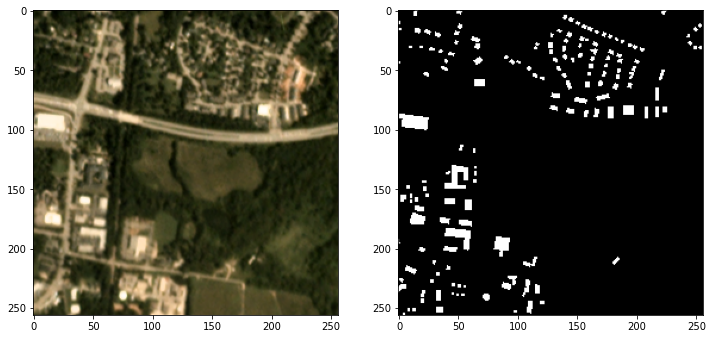

In [12]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:][...,::-1])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [18]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [19]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [20]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                     

In [21]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
45/45 [==============================] - 22s 439ms/step - loss: 0.3142 - accuracy: 0.9011 - val_loss: 121.0849 - val_accuracy: 0.1202
Epoch 2/100
45/45 [==============================] - 19s 427ms/step - loss: 0.2081 - accuracy: 0.9383 - val_loss: 1.3723 - val_accuracy: 0.4981
Epoch 3/100
45/45 [==============================] - 19s 427ms/step - loss: 0.1959 - accuracy: 0.9383 - val_loss: 0.2371 - val_accuracy: 0.9354
Epoch 4/100
45/45 [==============================] - 19s 427ms/step - loss: 0.1857 - accuracy: 0.9381 - val_loss: 0.2166 - val_accuracy: 0.9354
Epoch 5/100
45/45 [==============================] - 19s 427ms/step - loss: 0.1794 - accuracy: 0.9386 - val_loss: 0.2351 - val_accuracy: 0.9354
Epoch 6/100
45/45 [==============================] - 19s 427ms/step - loss: 0.1749 - accuracy: 0.9388 - val_loss: 0.2670 - val_accuracy: 0.9354
Epoch 7/100
45/45 [==============================] - 19s 427ms/step - loss: 0.1718 - accuracy: 0.9394 - val_loss: 0.2513 - val_accurac

In [22]:
#Save the model for future use
model.save('/content/drive/MyDrive/job_tasks/weights_colored_100.hdf5')

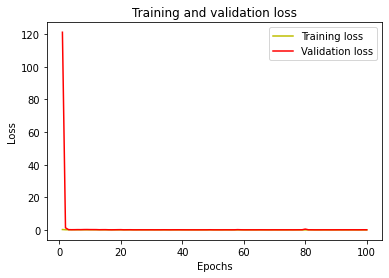

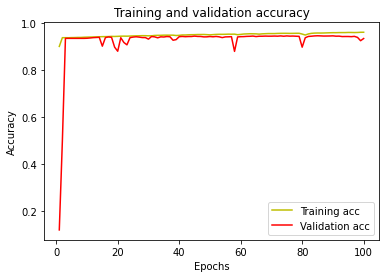

In [23]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/job_tasks/weights_colored_100.hdf5", compile=False)

In [26]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [27]:
from tensorflow.keras.metrics import MeanIoU

In [28]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.62092173


(1, 256, 256, 3)
(256, 256)


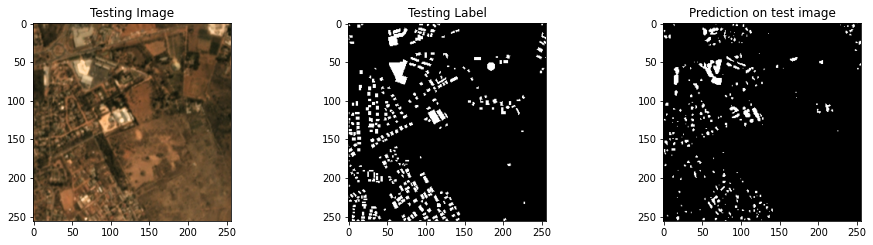

In [29]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[...,::-1])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()